# Problem Description

For this project, we are using GANs to generate images like Claude Monet's paintings. We are given training images of Monet's paintings, and we will be using them to try to recreate them. Since we are using GAN, we'll be building a generator and a discriminator for adversarial training.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Activation, Concatenate
from tensorflow.keras.backend import clear_session
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import backend as K

# Exploratory Data Analysis (EDA)

In [2]:
# data paths
monet_jpg_path = '/kaggle/input/gan-getting-started/monet_jpg/'
monet_tfrec_path = '/kaggle/input/gan-getting-started/monet_tfrec/'
photos_jpg_path = '/kaggle/input/gan-getting-started/photo_jpg/'
photos_tfrec_path = '/kaggle/input/gan-getting-started/photo_tfrec/'

In [3]:
# look at the data's size and details
monet_jpg_files = []
for f in os.listdir(monet_jpg_path):
    if f.lower().endswith('jpg'):
        monet_jpg_files.append(f)
print('Monet Painting Length (JPG):', len(monet_jpg_files))

monet_tfrec_files = []
for f in os.listdir(monet_tfrec_path):
    if f.lower().endswith('tfrec'):
        monet_tfrec_files.append(f)
print('Monet Painting Length (TFREC):', len(monet_tfrec_files))

photos_jpg_files = []
for f in os.listdir(photos_jpg_path):
    if f.lower().endswith('jpg'):
        photos_jpg_files.append(f)
print('Photo Image Length (JPG):', len(photos_jpg_files))

photos_tfrec_files = []
for f in os.listdir(photos_tfrec_path):
    if f.lower().endswith('tfrec'):
        photos_tfrec_files.append(f)

print('Photo Image Length (TFREC):', len(photos_tfrec_files))

# size of the painting and images
full_painting_path = os.path.join(monet_jpg_path + monet_jpg_files[0])
full_photo_path = os.path.join(photos_jpg_path + photos_jpg_files[0])
with Image.open(full_painting_path) as img:
    print('Monet Painting Details:', str(img.size))

with Image.open(full_photo_path) as img:
    print('Photo Image Details:', str(img.size))

Monet Painting Length (JPG): 300
Monet Painting Length (TFREC): 5
Photo Image Length (JPG): 7038
Photo Image Length (TFREC): 20
Monet Painting Details: (256, 256)
Photo Image Details: (256, 256)


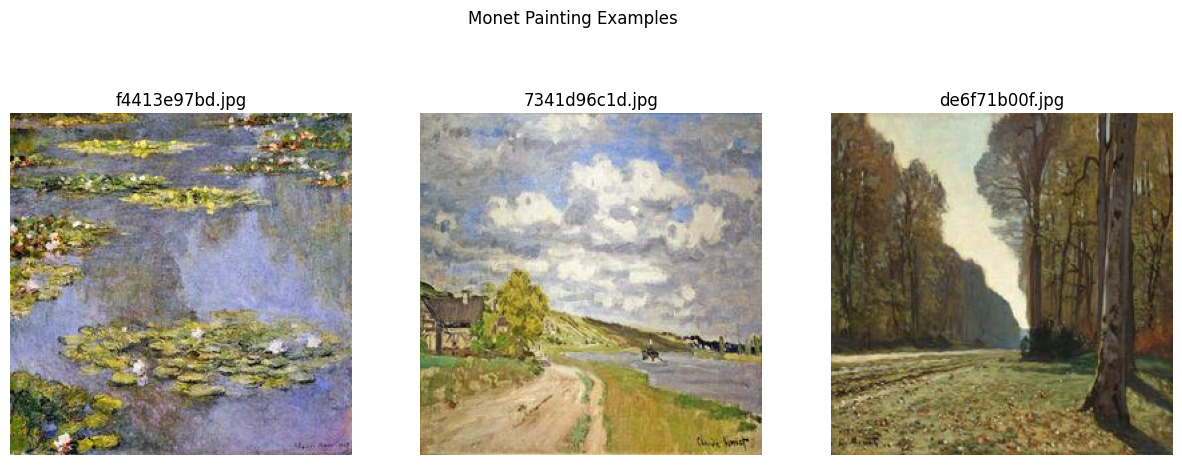

In [4]:
files = [f for f in os.listdir(monet_jpg_path) if f.lower().endswith(('jpg'))]
plt.figure(figsize=(15, 10))
for i, file_name in enumerate(files[:3]):
    file_path = os.path.join(monet_jpg_path, file_name)
    with Image.open(file_path) as img:
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')
plt.suptitle('Monet Painting Examples')
plt.show()

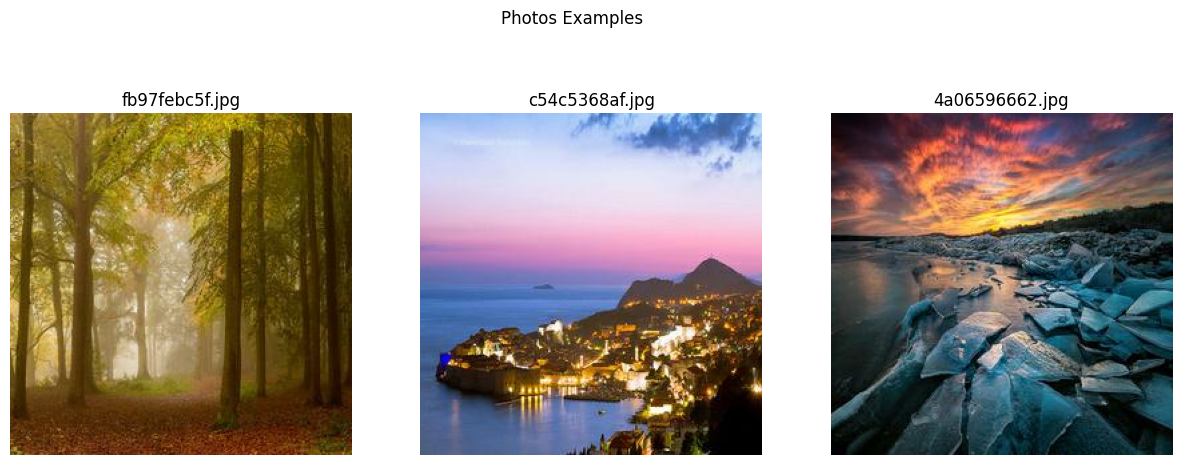

In [5]:
files = [f for f in os.listdir(photos_jpg_path) if f.lower().endswith(('jpg'))]
plt.figure(figsize=(15, 10))
for i, file_name in enumerate(files[:3]):
    file_path = os.path.join(photos_jpg_path, file_name)
    with Image.open(file_path) as img:
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')
plt.suptitle('Photos Examples')
plt.show()

**Findings**

Right off the bat, we can tell that the paintings look more artsy than the photos themselves. Photos images look sharper, edited, and are in higher resolution. Both the paintings and images are in 256 x 256 x 3 (RGB) dimension. 

In [6]:
def load_images(image_dir, max_images=100):
    image_files = os.listdir(image_dir)
    pixel_intensities = []

    # Limit the number of images to process
    for image_file in image_files[:max_images]:
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        pixel_values = np.array(image).flatten()     # Flatten the 2D image into a 1D array
        pixel_intensities.extend(pixel_values)

    return pixel_intensities

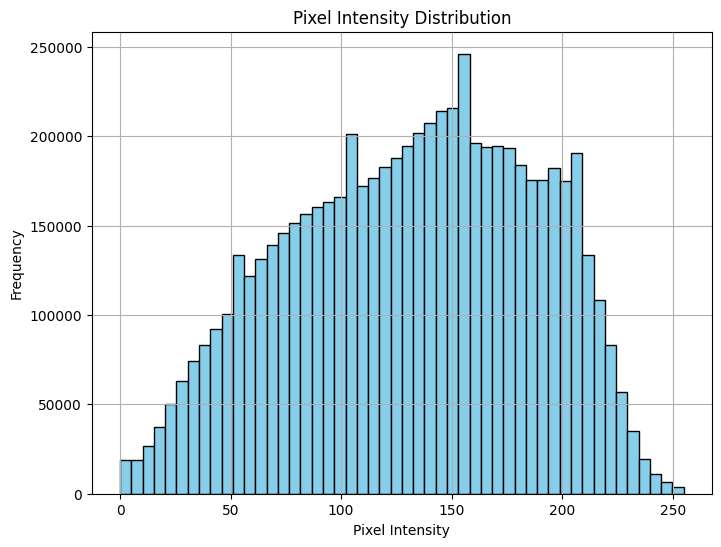

In [7]:
pixel_intensities = load_images(monet_jpg_path)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=50, color='skyblue', edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

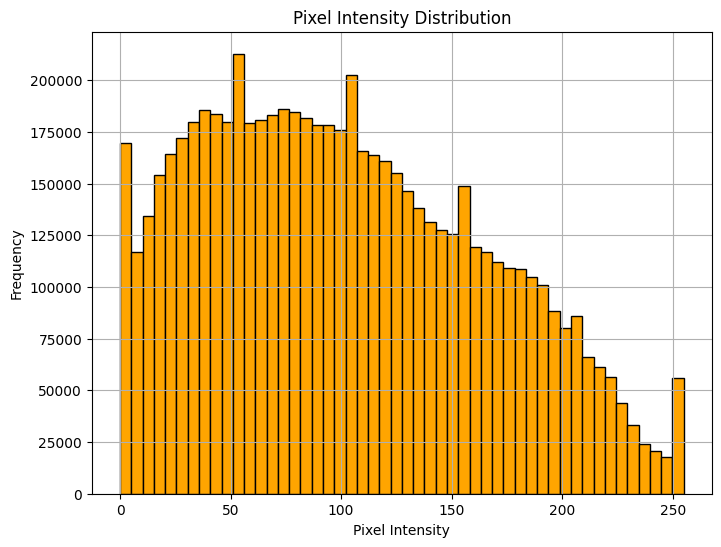

In [8]:
pixel_intensities = load_images(photos_jpg_path)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=50, color='orange', edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Findings**

Photos pixel intensity distribution:
* The intensities are skewed towards lower vlaues, indicating that the images are relatively dark overall. 
* Only a small portion of the images are on the bright side.

Monet paintings pixel intensity distribution:
* The distribution is more centered around mid-range, indicating that the images represented by this distribution are more balanced in terms of brightness and darkness. 
* Monet paintings, in contrast to photos, have fewer very dark pixels, indicating they are more diverse in colors.

Since the photos are more skewed to the left (dark), we might need to do some preprocesisng steps to normalize and standarize the pixel intensities, so the images that get generated from these won't be too dark.

# Model Architecture

**Data Preprocessing**

Here, we'll be using some code from the starter notebook to load and transform the tfrec image files. As the images are already set to size 256 x 256, we'll need to set the channel to 3, also to a scale between [-1, 1].

In [9]:
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset.prefetch(AUTOTUNE)

In [10]:
# load the datasets
monet_files = [os.path.join(monet_tfrec_path, f) for f in os.listdir(monet_tfrec_path)]
photos_files = [os.path.join(photos_tfrec_path, f) for f in os.listdir(photos_tfrec_path)]

monet_ds = load_dataset(monet_files, labeled=True).batch(4).prefetch(AUTOTUNE)
photo_ds = load_dataset(photos_files, labeled=True).batch(4).prefetch(AUTOTUNE)

In [11]:
print(monet_ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [12]:
print(photo_ds)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


**Building/Training Generator, Discriminator, and GAN models**

The GAN model will consist of two components: generator model and discriminator model. Generator model contains downsampling the input image, using convolutional layer to extract patterns and insights, using batchnormalization to lower training time, and leakyrelu as activation layer. For upsampling, it's similar process. We're using convolutional transpose layer to build up image dimensions, and using batchnormalization and leakyrelu as well. For discriminator, we're downsampling the images and using dropout and leakyrelu.

In [13]:
# implement generator
def build_generator(input_shape=(256, 256, 3), filters=(64, 128, 256)):
    generator_input = Input(shape=input_shape, name='generator_input')

    # Downsampling layers
    g1 = Conv2D(filters[0], 3, strides=2, padding='same', name='g_conv1')(generator_input)
    g1 = LeakyReLU(name='g_leakyrelu1')(g1)

    g2 = Conv2D(filters[1], 3, strides=2, padding='same', name='g_conv2')(g1)
    g2 = BatchNormalization(name='g_batchnorm2')(g2)
    g2 = LeakyReLU(name='g_leakyrelu2')(g2)

    g3 = Conv2D(filters[2], 3, strides=2, padding='same', name='g_conv3')(g2)
    g3 = BatchNormalization(name='g_batchnorm3')(g3)
    g3 = LeakyReLU(name='g_leakyrelu3')(g3)

    # Upsampling layers
    g4 = Conv2DTranspose(filters[1], 3, strides=2, padding='same', name='g_convT4')(g3)
    g4 = BatchNormalization(name='g_batchnorm4')(g4)
    g4 = LeakyReLU(name='g_leakyrelu4')(g4)
    g4 = Concatenate(name='g_concat1')([g4, g2])

    g5 = Conv2DTranspose(filters[0], 3, strides=2, padding='same', name='g_convT5')(g4)
    g5 = BatchNormalization(name='g_batchnorm5')(g5)
    g5 = LeakyReLU(name='g_leakyrelu5')(g5)
    g5 = Concatenate(name='g_concat2')([g5, g1])

    # Output layer
    generator_output = Conv2DTranspose(3, 3, strides=2, padding='same', activation='tanh', name='g_output')(g5)

    # Define the model
    generator_model = Model(generator_input, generator_output, name='Generator')
    return generator_model
    
generator_model = build_generator()
generator_model.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ generator_input     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_conv1 (Conv2D)    │ (None, 128, 128,  │      1,792 │ generator_input[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_leakyrelu1        │ (None, 128, 128,  │          0 │ g_conv1[0][0]     │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_conv2 (Conv2D)    │ (None, 64, 64,    │     73,856 │ g_leakyrelu1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_batchnorm2        │ (None, 64, 64,    │        512 │ g_conv2[0][0]     │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_leakyrelu2        │ (None, 64, 64,    │          0 │ g_batchnorm2[0][… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_conv3 (Conv2D)    │ (None, 32, 32,    │    295,168 │ g_leakyrelu2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_batchnorm3        │ (None, 32, 32,    │      1,024 │ g_conv3[0][0]     │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_leakyrelu3        │ (None, 32, 32,    │          0 │ g_batchnorm3[0][… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_convT4            │ (None, 64, 64,    │    295,040 │ g_leakyrelu3[0][… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_batchnorm4        │ (None, 64, 64,    │        512 │ g_convT4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_leakyrelu4        │ (None, 64, 64,    │          0 │ g_batchnorm4[0][… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_concat1           │ (None, 64, 64,    │          0 │ g_leakyrelu4[0][… │
│ (Concatenate)       │ 256)              │            │ g_leakyrelu2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_convT5            │ (None, 128, 128,  │    147,520 │ g_concat1[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_batchnorm5        │ (None, 128, 128,  │        256 │ g_convT5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_leakyrelu5        │ (None, 128, 128,  │          0 │ g_batchnorm5[0][… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_concat2           │ (None, 128, 128,  │          0 │ g_leakyrelu5[0][

 Total params: 819,139 (3.12 MB)

 Trainable params: 817,987 (3.12 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [14]:
# implement discriminator
def build_discriminator(input_shape=(256, 256, 3), filters=(64, 128, 256)):
    discriminator_input = Input(shape=input_shape, name='discriminator_input')

    # Convolutional layers
    d1 = Conv2D(filters[0], 3, strides=2, padding='same', name='d_conv1')(discriminator_input)
    d1 = LeakyReLU(name='d_leakyrelu1')(d1)
    d1 = Dropout(0.3, name='d_dropout1')(d1)

    d2 = Conv2D(filters[1], 3, strides=2, padding='same', name='d_conv2')(d1)
    d2 = LeakyReLU(name='d_leakyrelu2')(d2)
    d2 = Dropout(0.3, name='d_dropout2')(d2)

    d3 = Conv2D(filters[2], 3, strides=2, padding='same', name='d_conv3')(d2)
    d3 = LeakyReLU(name='d_leakyrelu3')(d3)
    d3 = Dropout(0.3, name='d_dropout3')(d3)

    # Flatten and output layer
    d4 = Flatten(name='d_flatten')(d3)
    discriminator_output = Dense(1, activation='sigmoid', name='d_output')(d4)

    # Define the model
    discriminator_model = Model(discriminator_input, discriminator_output, name='Discriminator')
    return discriminator_model

discriminator_model = build_discriminator()
discriminator_model.summary()

# Compile the discriminator model
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy']) # switched from 0.001 to 0.0002

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_input             │ (None, 256, 256, 3)    │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_conv1 (Conv2D)                │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_leakyrelu1 (LeakyReLU)        │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_dropout1 (Dropout)            │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_conv2 (Conv2D)                │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_leakyrelu2 (LeakyReLU)        │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_dropout2 (Dropout)            │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_conv3 (Conv2D)                │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_leakyrelu3 (LeakyReLU)        │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_dropout3 (Dropout)            │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_flatten (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ d_output (Dense)                │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,961 (2.41 MB)

 Trainable params: 632,961 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# create the GAN model and compile
gan_model = Sequential([
    generator_model,
    discriminator_model
])

gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [16]:
# plotting generator and discriminator loss
def plot_metric(ax, epochs, loss, accuracy, title, label_loss='Loss', label_acc='Accuracy', color_loss='blue', color_acc='red'):
    ax.plot(epochs, loss, label=f'{label_loss}', color=color_loss, linestyle='-', marker='o')
    ax.set_ylabel(f'{label_loss}', color=color_loss)
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.set_xlabel('Epochs')
    ax.set_title(title)

    # Create a second y-axis for accuracy
    ax2 = ax.twinx()
    ax2.plot(epochs, accuracy, label=f'{label_acc}', color=color_acc, linestyle='-', marker='x')
    ax2.set_ylabel(f'{label_acc}', color=color_acc)
    ax2.tick_params(axis='y', labelcolor=color_acc)
    
    ax.grid(True)

def plot_training_history(discriminator_history, generator_history):
    # Unpacking loss and accuracy
    d_loss, d_accuracy = zip(*discriminator_history)
    g_loss, g_accuracy = zip(*generator_history)
    
    epochs = range(1, len(d_loss) + 1)

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plotting discriminator history
    plot_metric(ax1, epochs, d_loss, d_accuracy, title='Discriminator Loss and Accuracy', 
                label_loss='Discriminator Loss', label_acc='Discriminator Accuracy', 
                color_loss='blue', color_acc='green')

    # Plotting generator history
    plot_metric(ax2, epochs, g_loss, g_accuracy, title='Generator Loss and Accuracy', 
                label_loss='Generator Loss', label_acc='Generator Accuracy', 
                color_loss='blue', color_acc='green')

    plt.tight_layout()
    plt.show()

In [17]:
def train_discriminator(discriminator_model, real_images, fake_images, batch_size):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator_model.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

    # return the avg discriminator loss
    return 0.5 * np.add(d_loss_real, d_loss_fake)

def train_generator(gan_model, real_images, batch_size):
    real_labels = np.ones((batch_size, 1))
    return gan_model.train_on_batch(real_images, real_labels)

def train_gan(generator_model, discriminator_model, gan_model, photo_ds, monet_ds, epochs, batch_size):
    # Lists to store training history
    discriminator_losses = []
    generator_losses = []

    # Calculate the total steps per epoch based on dataset sizes
    total_photos = len(list(photo_ds))
    total_monets = len(list(monet_ds))

    for epoch in range(epochs):
        d_loss_epoch = []
        g_loss_epoch = []

        # Create dataset iterators
        photo_iter = iter(photo_ds.repeat())
        monet_iter = iter(monet_ds.repeat())

        for step in range(min(total_photos, total_monets) // batch_size):
            # Get real photos and real Monet images for training
            real_photos = next(photo_iter)
            real_monets = next(monet_iter)

            # Generate fake Monet images using the generator
            fake_monets = generator_model.predict(real_photos, verbose=0)

            # Train the discriminator
            discriminator_model.trainable = True
            d_loss = train_discriminator(discriminator_model, real_monets, fake_monets, batch_size)
            d_loss_epoch.append(d_loss)

            # Train the generator (discriminator is frozen)
            discriminator_model.trainable = False
            g_loss = train_generator(gan_model, real_photos, batch_size)
            g_loss_epoch.append(g_loss[1:])  # Append only the relevant metrics (e.g., loss and accuracy)
        
        # Store loss
        discriminator_losses.append(np.mean(d_loss_epoch, axis=0))
        generator_losses.append(np.mean(g_loss_epoch, axis=0))

    return discriminator_losses, generator_losses

In [18]:
discriminator_losses, generator_losses = train_gan(generator_model, discriminator_model, gan_model, photo_ds, monet_ds, epochs=20, batch_size=4)

I0000 00:00:1728787904.802330      67 service.cc:145] XLA service 0x7b8370026e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728787904.802399      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728787906.259405      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Results and Analysis

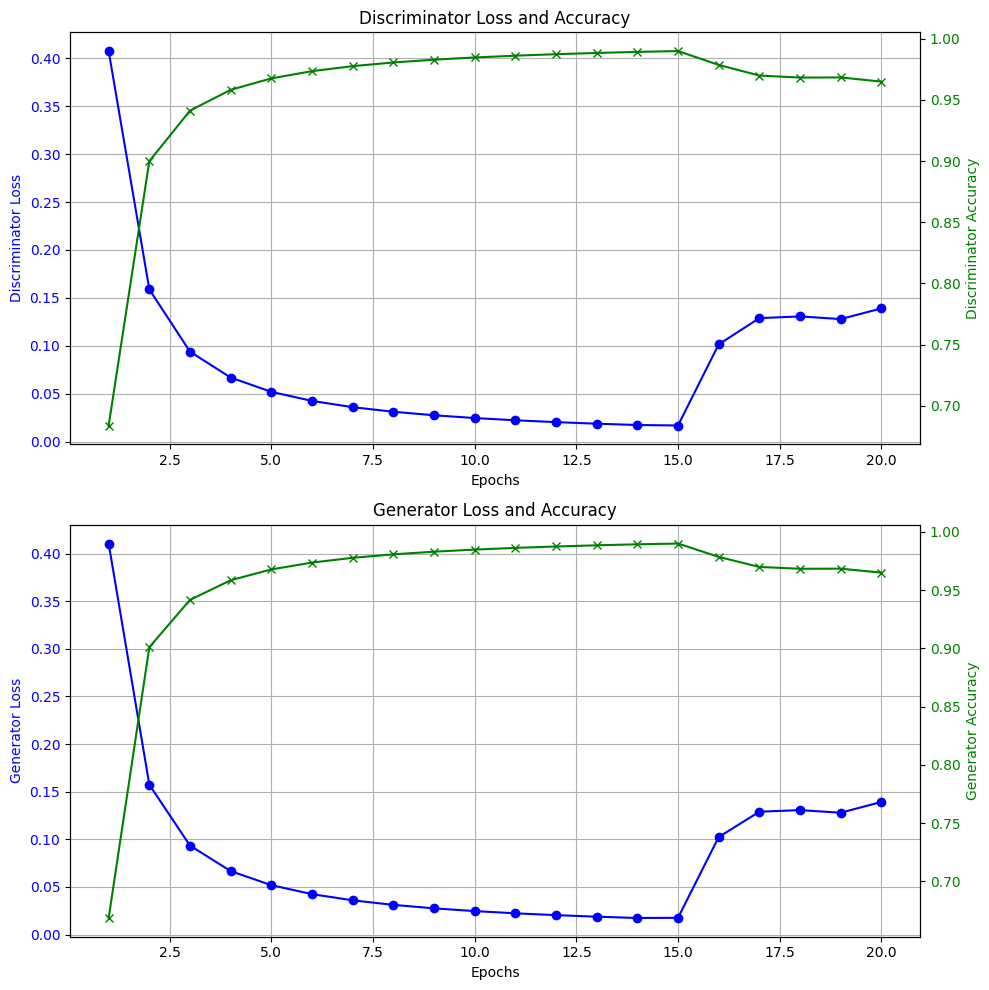

In [19]:
plot_training_history(discriminator_losses, generator_losses)

**Findings**

* We can tell from the graphs that discriminator and generator loss eventually decreased to a point where it became saturated and evens out.
* Accuracy also performed pretty well
* For hyperparameter tuning, I actually tried a few variations:
  - epoch: 25, learning rate: 0.001
  - epoch: 10, learning rate 0.1
  These all performed poorly and as the generator and discriminator loss would spike up out of nowhere and becomes unstable.
* After modifying my parameters a bit, i came to a conclusion where epoch: 20, learning rate 0.0002 are the most suitable combination.

**Improvements**

If I had more time to further improve my GAN training, I would:
* Try tinkering a bit more with the parameters such as batch size, epoch, learning rate, beta values, etc.
* Try other variations of GAN to see if they give different or better results.

# Submission

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


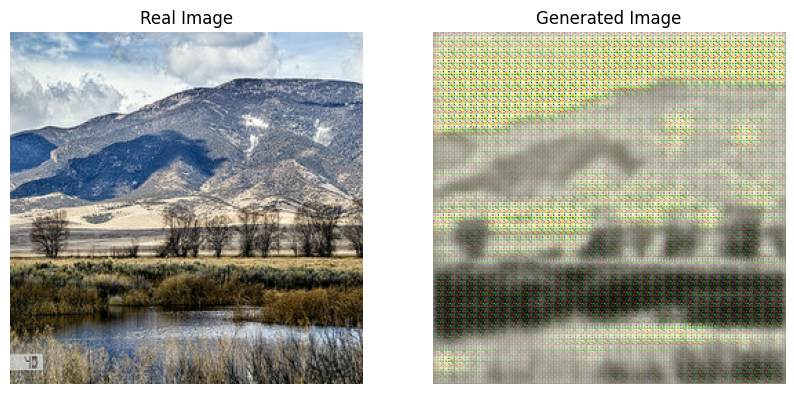

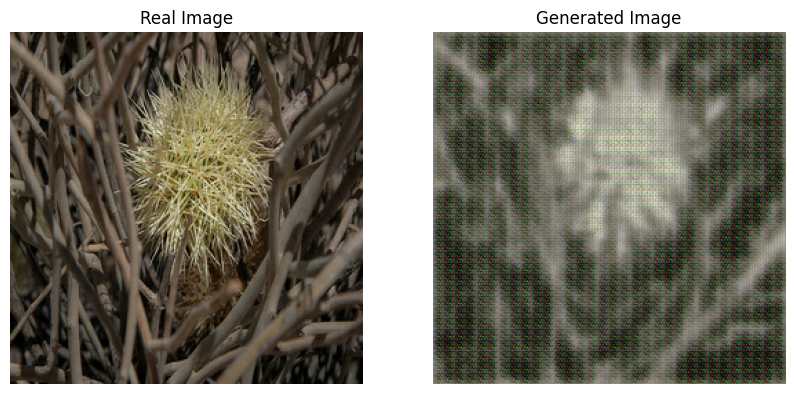

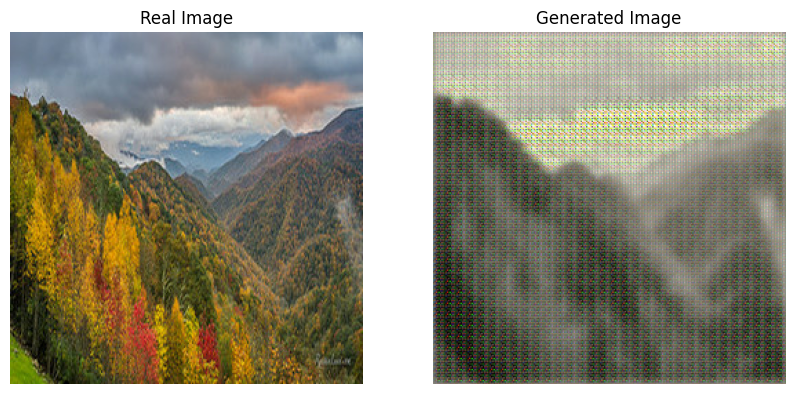

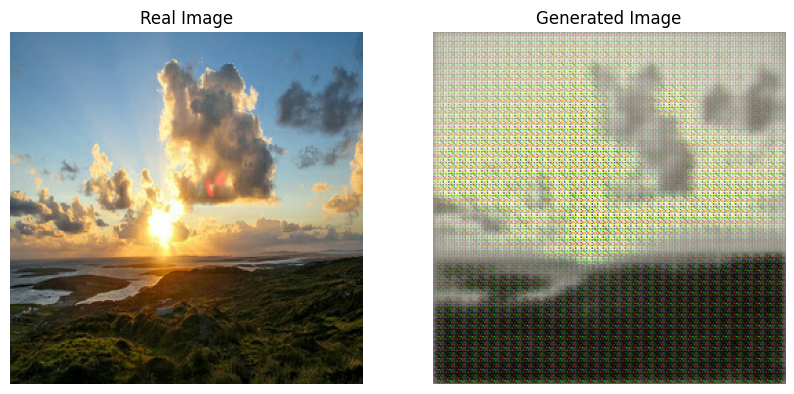

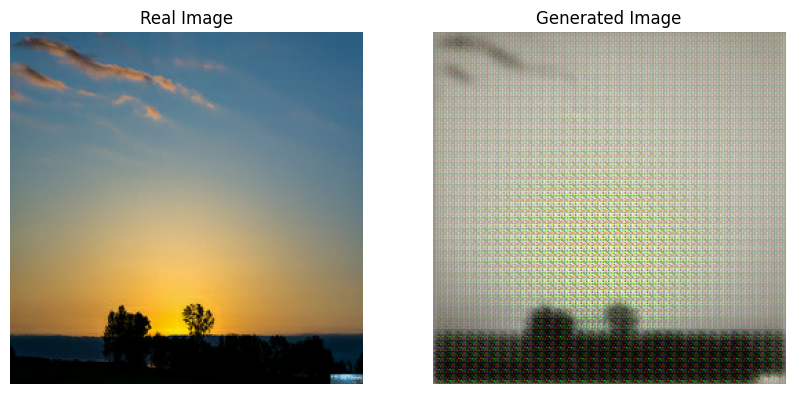

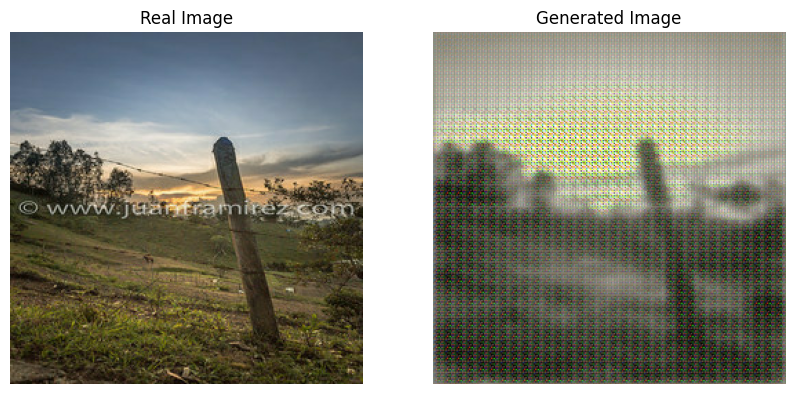

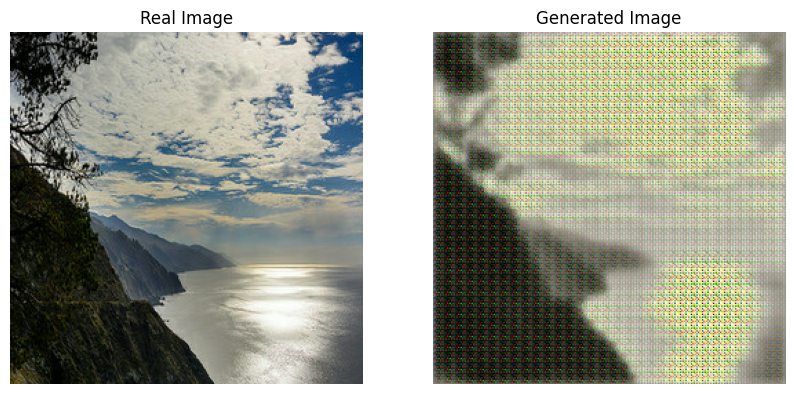

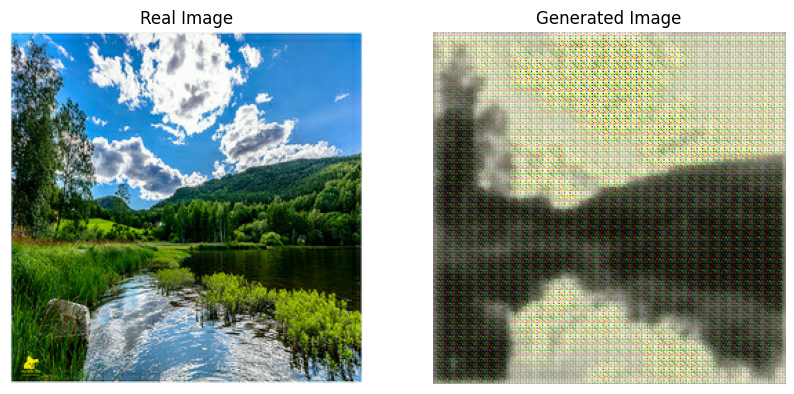

In [20]:
import os
import shutil
import PIL

!rm -rf /kaggle/working/*

def create_image_dir(path):
    os.makedirs(path, exist_ok=True)

# Rescale images from [-1, 1] to [0, 255] and convert to uint8
def rescale_image(image):
    return ((image + 1) * 127.5).astype(np.uint8)

# Save generated images as JPGs
def save_image(image_array, file_path):
    image_pil = Image.fromarray(image_array)
    image_pil.save(file_path)

# Display generated and real images
def display_images(real_image, fake_image, counter):
    if counter % 1000 == 0:  # Display images every 50 steps
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(real_image)
        ax[0].set_title('Real Image')
        ax[0].axis('off')

        ax[1].imshow(fake_image)
        ax[1].set_title('Generated Image')
        ax[1].axis('off')

        plt.show()

# Main function to process and save images
def generate_and_save_images(generator_model, photo_dataset, save_dir, display=False):
    create_image_dir(save_dir)
    counter = 0
    
    for real_img in photo_dataset:
        # Generate Monet-style image from real image
        fake_img = generator_model.predict(real_img, verbose=0)

        # Rescale both the real and generated images
        real_img_rescaled = rescale_image(real_img.numpy()[0])
        fake_img_rescaled = rescale_image(fake_img[0])

        # Save the generated fake image
        save_image(fake_img_rescaled, f"{save_dir}/{counter}.jpg")

        # Optionally display images
        if display:
            display_images(Image.fromarray(real_img_rescaled), Image.fromarray(fake_img_rescaled), counter)

        counter += 1

    shutil.make_archive(save_dir, 'zip', save_dir)

save_directory = "/kaggle/working/images"
photo_dataset = load_dataset(photos_files, labeled=True).batch(1)
generate_and_save_images(generator_model, photo_dataset, save_directory, display=True)

**GitHub URL**

https://github.com/rx24race/csca5642_week5

**Reference**

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial